#### Import block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

from sklearn.utils import class_weight

%matplotlib inline

In [2]:
# Check for available GPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Function definitions

In [3]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    # Load array.
    t_input = np.load(path)
    # Pad to even number of pixels
    t_input = np.pad(t_input, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    t_input = tf.expand_dims(t_input, axis = -1)
    return t_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    # Pad to even number of pixels
    t_output = np.pad(t_output, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    t_output = tf.expand_dims(t_output, axis = -1)
    return t_output

def data_generator(samples, batch_size = 64):
    
    while True:
        # Select files (paths/indices) for the batch
        batch_samples  = np.random.choice(a = samples.index, 
                                      size = batch_size)
        batch_input  = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for sample in batch_samples:
          input = get_input(samples.loc[sample].features)
          output = get_output(samples.loc[sample].labels)

          batch_input += [input]
          batch_output += [output]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)


In [4]:
m = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
m

,Unnamed: 0,Lon,Lat,Date,features,labels
0,356962,-53.345535,-6.535028,2017-07-30,Sample_CLSTM_Dataset/train/features/356962.npy,Sample_CLSTM_Dataset/train/labels/356962.npy
1,546517,-47.329685,-8.260676,2017-08-20,Sample_CLSTM_Dataset/train/features/546517.npy,Sample_CLSTM_Dataset/train/labels/546517.npy
2,799359,-50.967861,-8.255809,2017-09-04,Sample_CLSTM_Dataset/train/features/799359.npy,Sample_CLSTM_Dataset/train/labels/799359.npy
3,714590,-66.144379,-12.624272,2017-08-31,Sample_CLSTM_Dataset/train/features/714590.npy,Sample_CLSTM_Dataset/train/labels/714590.npy
4,240012,-48.350338,-11.838207,2017-07-14,Sample_CLSTM_Dataset/train/features/240012.npy,Sample_CLSTM_Dataset/train/labels/240012.npy
...,...,...,...,...,...,...
6491,173827,-54.326607,-11.983384,2017-06-20,Sample_CLSTM_Dataset/train/features/173827.npy,Sample_CLSTM_Dataset/train/labels/173827.npy
6492,1377764,-47.425915,-7.486426,2017-09-26,Sample_CLSTM_Dataset/train/features/1377764.npy,Sample_CLSTM_Dataset/train/labels/1377764.npy
6493,1444041,-65.172768,-10.714162,2017-10-02,Sample_CLSTM_Dataset/train/features/1444041.npy,Sample_CLSTM_Dataset/train/labels/1444041.npy
6494,644793,-53.701656,-15.977278,2017-08-27,Sample_CLSTM_Dataset/train/features/644793.npy,Sample_CLSTM_Dataset/train/labels/644793.npy


#### Load data

In [5]:
# Get data from one chip
sample_input = np.load('Sample_CLSTM_Dataset/train/features/3243.npy')

# Pad to even number of pixels
a = np.pad(sample_input, [(0,0),(0,1),(0,1)])
# Resize to include a channel dimension.
a = tf.expand_dims(a, axis = -1)
# Resize to include a batch dimension.
a = tf.expand_dims(a, axis = 0)
# Display shape for verification.
a.shape

TensorShape([1, 10, 32, 32, 1])

#### Model assumbly

In [6]:
# Inspired by: https://keras.io/examples/vision/conv_lstm/?fbclid=IwAR1QSJmF0bcz5pklHDHwl4mUi8inzHN4m8Zk6OpvVJizqDDv2-MKMq3LlJ8

inputs = layers.Input(shape=((10,32,32,1)))
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation='relu',
)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation='relu',
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=True,
    activation='relu',
)(x)
outputs = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'
)(x)

In [7]:
forecast_model = tf.keras.Model(inputs, outputs, name="Conv_LSTM")

In [8]:
# Verify output shape.
forecast_model.predict(a).shape

1/1 [==============================] - 2s 2s/step


(1, 10, 32, 32, 1)

In [9]:
# Display model details.
forecast_model.summary()

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 32, 32, 1)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    416256    
                                                                 
 batch_normalization (BatchN  (None, 10, 32, 32, 64)   256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
                                                                 
 batch_normalization_1 (Batc  (None, 10, 32, 32, 64)   256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 10, 32, 32, 64)    33

In [10]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
forecast_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
# Data loaders.
batch_size = 64
meta_t = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
meta_v = pd.read_csv('Sample_CLSTM_Dataset/val/meta.csv')
t_gen = data_generator(meta_t, batch_size = batch_size)
v_gen = data_generator(meta_v, batch_size = batch_size)

In [11]:
# Trying new approach to build dataset.
x_train, y_train, x_val, y_val = [],[],[],[]

# Iterate over dataset.
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[0].features))
    y_train.append(np.load(meta_t.iloc[0].labels))
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[0].features))
    y_val.append(np.load(meta_v.iloc[0].labels))
    
# Stack layers.
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)

# Convert values > 1 to 1.
x_train = np.minimum(x_train,1)
y_train = np.minimum(y_train,1)
x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)

# Pad to even shape.
x_train = np.pad(x_train, [(0,0),(0,0),(0,1),(0,1)])
y_train = np.pad(y_train, [(0,0),(0,0),(0,1),(0,1)])
x_val = np.pad(x_val, [(0,0),(0,0),(0,1),(0,1)])
y_val = np.pad(y_val, [(0,0),(0,0),(0,1),(0,1)])

# Add color channel dim.
x_train = tf.expand_dims(x_train, axis = -1)
y_train = tf.expand_dims(y_train, axis = -1)
x_val = tf.expand_dims(x_val, axis = -1)
y_val = tf.expand_dims(y_val, axis = -1)

In [22]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [19]:
# Get class weights for weighted binary cross entropy loss.
weights = class_weight.compute_class_weight('balanced',
                                            [0,1],
                                            y_train.numpy().flatten())

#weights = {i : weights[i] for i in range(0,2)}
weights

array([  0.5010275 , 243.80952381])

In [23]:
calculated_sample_weights = generate_sample_weights(y_train, weights)

In [25]:
# Params
batch_size = 32

# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Train model.
forecast_model.fit(#t_gen, 
                   x_train,
                   y_train,
                   epochs = 50, 
                   verbose = 1, 
                   batch_size = batch_size,
                   #validation_data = v_gen, 
                   validation_data = (x_val, y_val),
                   #steps_per_epoch = len(meta_t) // batch_size,
                   #validation_steps = len(meta_v) // batch_size,
                   callbacks = [early_stopping, reduce_lr],
                   #class_weight = weights
                   sample_weight = calculated_sample_weights
                  )

Epoch 1/50
203/203 [==============================] - 64s 302ms/step - loss: 0.6559 - accuracy: 0.6826 - val_loss: 0.6822 - val_accuracy: 0.9999 - lr: 1.0000e-05
Epoch 2/50
203/203 [==============================] - 61s 300ms/step - loss: 0.4184 - accuracy: 0.8725 - val_loss: 0.4116 - val_accuracy: 0.8908 - lr: 1.0000e-05
Epoch 3/50
203/203 [==============================] - 61s 301ms/step - loss: 0.3251 - accuracy: 0.8851 - val_loss: 0.2050 - val_accuracy: 0.8999 - lr: 1.0000e-05
Epoch 4/50
203/203 [==============================] - 61s 300ms/step - loss: 0.2690 - accuracy: 0.8564 - val_loss: 0.2041 - val_accuracy: 0.9022 - lr: 1.0000e-05
Epoch 5/50
203/203 [==============================] - 61s 301ms/step - loss: 0.2403 - accuracy: 0.8473 - val_loss: 0.2417 - val_accuracy: 0.9009 - lr: 1.0000e-05
Epoch 6/50
203/203 [==============================] - 61s 301ms/step - loss: 0.2239 - accuracy: 0.8269 - val_loss: 0.2386 - val_accuracy: 0.8057 - lr: 1.0000e-05
Epoch 7/50
203/203 [========

In [26]:
# Save trained model.
forecast_model.save('Models/008')

INFO:tensorflow:Assets written to: Models/008\assets


INFO:tensorflow:Assets written to: Models/008\assets


In [7]:
forecast_model = tf.keras.models.load_model('Models/008')

#### Examine how model is working

In [29]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    pred_frames.append(predicted_frame)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 0s 38ms/step


In [35]:
# Shape verification.
feature_frames.shape == label_frames.shape == pred_frames.shape

True

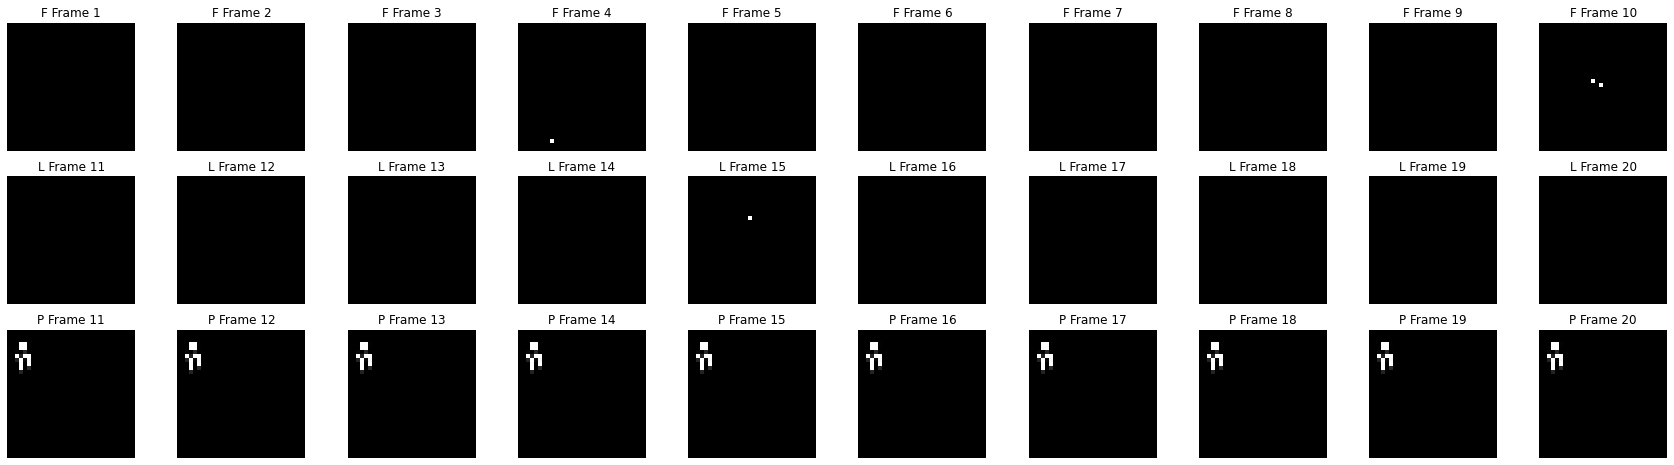

In [45]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(3, 10, figsize=(30, 8))

# Plot the feature frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(feature_frames[idx]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")

# Plot the label frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(label_frames[idx]), cmap="gray")
    ax.set_title(f"L Frame {idx + 11}")
    ax.axis("off")
    
# Plot the predicted frames.
for idx, ax in enumerate(axes[2]):
    ax.imshow(np.squeeze(pred_frames[idx]), cmap="gray")
    ax.set_title(f"P Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()